In [41]:
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from deap import base, creator, tools, algorithms
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from xgboost import XGBClassifier
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE




## Utils

In [42]:
def calc_metrics(y_true, y_pred, name):
    print(f'Посчитанные метрики для {name}: ')
    print("Accuracy: ", round(accuracy_score(y_true, y_pred), 4))
    print("Recall: ", round(recall_score(y_true, y_pred), 4))
    print("Precision: ", round(precision_score(y_true, y_pred), 4))
    print("F1: ", round(f1_score(y_true, y_pred), 4))
    print("ROC/AUC: ", round(roc_auc_score(y_true, y_pred), 4))
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Reading and preproc. data

In [43]:
df = pd.read_csv('../data/adult.csv')
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [44]:
df.replace('?', pd.NA, inplace=True)
df.dropna(inplace=True)

In [45]:
df['income'] = df['income'].apply(lambda x: 1 if x == ">50K" else 0)
print(df['income'].value_counts(normalize=True))

new_df = df.copy()

income
0    0.751078
1    0.248922
Name: proportion, dtype: float64


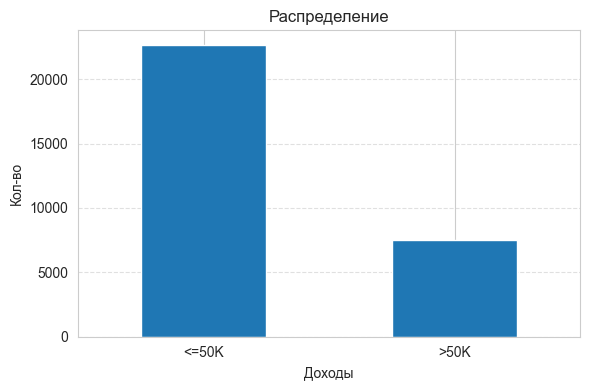

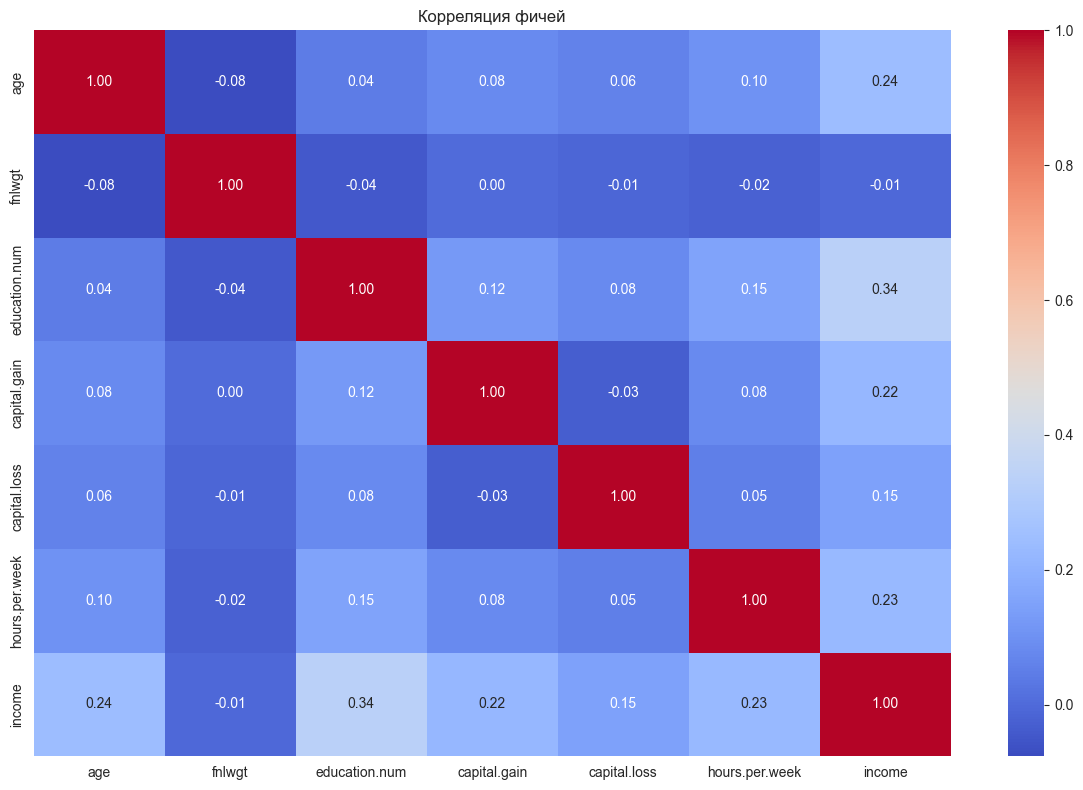

In [48]:
plt.figure(figsize=(6, 4))
df['income'].value_counts().plot(kind='bar', title='Распределение')
plt.xticks(ticks=[0, 1], labels=['<=50K', '>50K'], rotation=0)
plt.xlabel('Доходы')
plt.ylabel('Кол-во')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляция фичей")
plt.tight_layout()
plt.show()

   

In [6]:
target = new_df['income']
new_df.drop('income', axis=1, inplace=True)

In [7]:
new_df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States


In [8]:
X_train, X_test, y_train, y_test = train_test_split(new_df, target, test_size=0.2, random_state=42, stratify=target, shuffle=True)

In [9]:
cat_cols = new_df.select_dtypes(include='object').columns
num_cols = new_df.select_dtypes(include=['int64', 'float64']).columns

In [10]:
# scaler = MinMaxScaler()
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

In [11]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

In [12]:
X_train_final = np.hstack((X_train_num, X_train_cat))
X_test_final = np.hstack((X_test_num, X_test_cat))

### Balance data

In [13]:
smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train_final, y_train)


In [14]:
y_train_balanced.value_counts(normalize=True)

income
0    0.5
1    0.5
Name: proportion, dtype: float64

### 1 Модель XGBoost

In [20]:
model_XGBoost = XGBClassifier(eval_metric='logloss', random_state=42)

model_XGBoost.fit(X_train_balanced, y_train_balanced)

y_pred = model_XGBoost.predict(X_test_final)

In [21]:
calc_metrics(y_test, y_pred, "XGBoost")

Посчитанные метрики для XGBoost: 
Accuracy:  0.8629
Recall:  0.7597
Precision:  0.71
F1:  0.734
ROC/AUC:  0.8284


In [24]:
with open('../models/XGBoost.pkl', 'wb') as f:
    pickle.dump(model_XGBoost, f)

### 2 модель на PyTorch

In [25]:
class DataSet(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [26]:
class ANet(nn.Module):
    def __init__(self, input_dim):
        super(ANet, self).__init__()
        self.net = nn.Sequential(
            
            nn.Linear(input_dim, 53),
            # nn.BatchNorm1d(87),
            nn.ReLU(),

            nn.Linear(53, 15),
            nn.ReLU(),

            nn.Linear(15, 18),
            nn.ReLU(),
            
            nn.Linear(18, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.net(x)

In [27]:

def train_test_model(model, train_loader, test_loader, lr, epochs):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred_out = model(x_batch)
            loss = criterion(y_pred_out.squeeze(1), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader)}")
    
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred_out = model(x_batch).squeeze()
            preds.extend((y_pred_out > 0.5).int().cpu().tolist())
            targets.extend(y_batch.cpu().tolist())
    
    calc_metrics(targets, preds, "ANet")
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, )
    return acc

In [28]:
train_dataset = DataSet(X_train_balanced, y_train_balanced)
test_dataset = DataSet(X_test_final, np.array(y_test))

In [29]:
train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [32]:
model = ANet(input_dim=X_train_balanced.shape[1])
train_test_model(model, train_loader, test_loader, 0.000032, 10)

 10%|█         | 1/10 [00:01<00:13,  1.53s/it]

Epoch 1/10, Loss: 0.6919208289874714


 20%|██        | 2/10 [00:02<00:10,  1.28s/it]

Epoch 2/10, Loss: 0.6774719616092703


 30%|███       | 3/10 [00:03<00:08,  1.20s/it]

Epoch 3/10, Loss: 0.6333044688537638


 40%|████      | 4/10 [00:04<00:06,  1.15s/it]

Epoch 4/10, Loss: 0.5643730888921747


 50%|█████     | 5/10 [00:05<00:05,  1.14s/it]

Epoch 5/10, Loss: 0.49779259469984277


 60%|██████    | 6/10 [00:07<00:04,  1.13s/it]

Epoch 6/10, Loss: 0.45151061303190876


 70%|███████   | 7/10 [00:08<00:03,  1.12s/it]

Epoch 7/10, Loss: 0.42419233437253057


 80%|████████  | 8/10 [00:09<00:02,  1.12s/it]

Epoch 8/10, Loss: 0.4084533620921392


 90%|█████████ | 9/10 [00:10<00:01,  1.11s/it]

Epoch 9/10, Loss: 0.39900558403770336


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

Epoch 10/10, Loss: 0.39283204007716405
Посчитанные метрики для ANet: 
Accuracy:  0.7517
Recall:  0.9401
Precision:  0.5007
F1:  0.6534
ROC/AUC:  0.8147


0.7516989888944141

In [33]:
torch.save(model.state_dict(), '../models/model.pth')

### Поиск оптимальных параметров для ANN с помошью GA 

In [333]:
import torch
import torch.nn as nn
import torch.optim as optim


class Net(nn.Module):
    def __init__(self, input_dim, n1, n2,n3, activation, use_bn):
        super(Net, self).__init__()

        act_fn = {
            "relu": nn.ReLU(),
            "leakyrelu": nn.LeakyReLU(),
            "tanh": nn.Tanh()
        }[activation]

        layers = [nn.Linear(input_dim, n1)]
        if use_bn:
            layers.append(nn.BatchNorm1d(n1))
        layers.append(act_fn)
        layers.append(nn.Linear(n1, n2))
        layers.append(act_fn)
        layers.append(nn.Linear(n2, n3)), 
        layers.append(act_fn),
        layers.append(nn.Linear(n3, 1))
        layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [343]:
def evaluate_individual(individual, input_dim, train_loader, test_loader):
    n1, n2, n3, act_idx, bn_flag, lr = individual
    n1 = max(4, int(round(n1)))
    n2 = max(4, int(round(n2)))
    n3 = max(4, int(round(n3)))
    activation = ["relu", "leakyrelu", "tanh"][int(round(act_idx)) % 3]
    use_bn = bool(round(bn_flag))

    model = Net(input_dim, n1, n2, n3, activation, use_bn)
    metrics = train_test_model(model, train_loader, test_loader, lr=lr, epochs=5, return_metrics=True)
    

    composite_score = 0.5*metrics['f1'] + 0.3*metrics['roc_auc'] + 0.2*metrics['accuracy']
    return (composite_score,)

In [344]:
# Настройка DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_n1", random.uniform, 16, 128)  
toolbox.register("attr_n2", random.uniform, 4, 64)   
toolbox.register("attr_n3", random.uniform, 4, 32) 
toolbox.register("attr_act", random.randint, 0, 2)
toolbox.register("attr_bn", random.randint, 0, 1)
toolbox.register("attr_lr", random.uniform, 1e-5, 1e-3)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_n1, toolbox.attr_n2, toolbox.attr_n3, 
                  toolbox.attr_act, toolbox.attr_bn, toolbox.attr_lr), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_individual, 
                 input_dim=X_train_balanced.shape[1],
                 train_loader=train_loader,
                 test_loader=test_loader)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutPolynomialBounded, 
                 low=[16.0, 4.0, 4.0, 0.0, 0.0, 1e-5],  # Все значения как float
                 up=[128.0, 64.0, 32.0, 2.0, 1.0, 1e-3],  # Все значения как float
                 eta=0.5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

C:\Users\nikit\PycharmProjects\adult-income-prediction\.venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\nikit\PycharmProjects\adult-income-prediction\.venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
def run_ga():
    pop = toolbox.population(n=10)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    
    algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=3, 
                        stats=stats, halloffame=hof, verbose=True)
    
    best_ind = hof[0]
    print(f"Лучший индивид: n1={best_ind[0]:.0f}, n2={best_ind[1]:.0f}, n3={best_ind[2]:.0f}, "
          f"act={['relu','leakyrelu','tanh'][int(best_ind[3])]}, bn={bool(best_ind[4])}, "
          f"lr={best_ind[5]:.6f}")
    
    return best_ind

best_individual = run_ga()

### 3 Модель

In [19]:
RFC = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)

RFC.fit(X_train_balanced, y_train_balanced)

RFC_pred = RFC.predict(X_test_final)

calc_metrics(y_test, RFC_pred, "RFC")

Посчитанные метрики для RFC: 
Accuracy:  0.8357
Recall:  0.8242
Precision:  0.63
F1:  0.7142
ROC/AUC:  0.8319


In [34]:
with open('../models/RFC.pkl', 'wb') as f:
    pickle.dump(RFC, f)

KeyError: 'income'

<Figure size 600x400 with 0 Axes>